## Initial preparations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import functional as F

device = 'cuda' if torch.cuda else 'cpu'
torch.cuda.is_available(), torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated()

(True, 0, 0)

## Dataset: Tiny Shakespeare

### Download

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-05-17 17:23:11--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  6.66MB/s    in 0.2s    

2023-05-17 17:23:11 (6.66 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [3]:
with open("input.txt", 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print(len(text))

1115394


In [5]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



### Building vocabular

In [6]:
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print("".join(vocab))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### Tokenizing

Revise tokenisers:

- SentencePiece powered by Google
- TikToken

In [7]:
stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for i,ch in enumerate(vocab)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda L: [itos[i] for i in L]

print(encode("hello, world!"))
print(''.join(decode(encode("hello, world!"))))

[46, 43, 50, 50, 53, 6, 1, 61, 53, 56, 50, 42, 2]
hello, world!


In [8]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

### Train/Validation split

In [9]:
train_size = int(0.9*len(data))
train_X    = data[:train_size]
val_X      = data[train_size:]
print(train_size)

1003854


### Setup block_size - maximum context length

- context length - count of tokens in a continious line prior target token

In [10]:
block_size = 8
train_X[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
example_x = train_X[:block_size]
example_y = train_X[1:block_size+1]
for t in range(block_size):
    context = example_x[:t+1]
    target = example_y[t]
    print(f"when input is {context} the target is {target}")

when input is tensor([18]) the target is 47
when input is tensor([18, 47]) the target is 56
when input is tensor([18, 47, 56]) the target is 57
when input is tensor([18, 47, 56, 57]) the target is 58
when input is tensor([18, 47, 56, 57, 58]) the target is 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target is 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is 58


In [12]:
torch.manual_seed(1337)
batch_size = 4

def get_batch(split, batch_size=4):
    data = train_X if split == 'train' else val_X
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x  = torch.stack([data[i:i+block_size] for i in ix])
    y  = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


In [13]:
batch_size = 4
xb, yb = get_batch('train', batch_size)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]], device='cuda:0')
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] th

### Baseline: Bigram Language Model

In [14]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dims=vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dims = embedding_dims
        self.tocken_embedding_table = nn.Embedding(vocab_size, embedding_dims)

    def forward(self, idx):
        return self.tocken_embedding_table(idx)

    def compute_loss(self, logits, targets):
        N, T, C = logits.shape
        return F.cross_entropy(logits.view(N*T, C), targets.view(N*T))

    def generate(self, initial_context, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(initial_context)
            last_time_step_logits = logits[:,-1,:]
            probs = F.softmax(last_time_step_logits, dim=1)
            context_next = torch.multinomial(probs, num_samples=1)
            initial_context = torch.cat((initial_context, context_next), dim=1)
        return initial_context

    def generate_string(self, initial_context, max_new_tokens):
        return ''.join(
            decode(
                self.generate(initial_context, max_new_tokens=max_new_tokens)[0].tolist()
            )
        )


m = BigramLanguageModel(vocab_size).to(device)
logits = m(xb)
loss = m.compute_loss(logits, yb)
print(logits.shape)
print(loss)

torch.Size([4, 8, 65])
tensor(4.8786, device='cuda:0', grad_fn=<NllLossBackward0>)


In [15]:
-np.log(1/65)

4.174387269895637

In [16]:
initial_context = torch.zeros((1,1), dtype=torch.long, device=device)
print(m.generate_string(initial_context, max_new_tokens=100))


pYCXxfRkRZd
wc'wfNfT;OLlTEeC K
jxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a
hs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe


In [17]:
batch_size = 32
eval_iters = 200
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-2)
for steps in range(1000):
    xb, yb = get_batch("train")
    logits = m(xb)
    loss = m.compute_loss(logits, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

2.468719244003296


In [18]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(m.generate_string(context, max_new_tokens=500))


Wawice my.

TDER:
AnzCENup
Yow&$FMOUf is h bot m Whedill, ath iree s, hein lat HNGAd ov ts, and Wk p.
GSp.
Swanousel lind me l.
MAul, cechiry:
Supr aisspllw y.
Jllinke n Bfopetelaves;qke

Pl, d metSPkllo W-wou wh tCois 3s wouth dourivETENGShire s poo K:

PxTre

AL:

Inthrupt f s ar iris! m:

Thin maleronth, af Pre?d mySo myr KINLIE!
Ktidb&y, wardsal acesE:zLAnd din cNuk ay aney Iry ts I&fr af vNGJMOnEETonoke mary.
Yof 'soug me?m sora an hse.
Spond by we men.
Sand s st sulin s th llugivod, wimmuc


### Denoise loss calculation

In [19]:
class LossEstimator:
    
    def __init__(self, eval_step):
        self.eval_step = eval_step

    @torch.no_grad()
    def estimate_loss(self, model):
        estimations = dict()
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(self.eval_step)
            for k in range(self.eval_step):
                X, y = get_batch(split)
                logits = model(X)
                loss = model.compute_loss(logits, y)
                losses[k] = loss.item()
            estimations[split] = losses.mean().item()
        model.train()
        return estimations

### Collect all the training stuff into a single method

It includes:
- average loss estimations through batch of samples
- average losses for both train and valdidation split
- Adam optimizer with weights penalty
- learning_rate decay on plateau

In [20]:
def train(model, iterations, batch_size, optimizer, lr_scheduler, loss_estimator):
    loss_history = {"train": [], "val": []} 
    for i in range(iterations):
        if i % loss_estimator.eval_step == 0:
            losses = loss_estimator.estimate_loss(model)
            print(f"step {i} losses:", end=" ") 
            for split, loss_value in losses.items():
                loss_history[split].append(loss_value)
                print(f"{split} {losses['train']:.4f},", end=" ")
            lr_scheduler.step(losses['train'])
            print()
        xb, yb = get_batch('train', batch_size)
        logits = model(xb)
        loss = model.compute_loss(logits, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return loss_history


In [21]:
model = BigramLanguageModel(vocab_size).to(device)
iterations = 2000
batch_size = 32
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
loss_estimator = LossEstimator(eval_step=200)

In [22]:
initial_context = torch.zeros((1,1), dtype=torch.long, device=device)
print(model.generate_string(initial_context, max_new_tokens=100))


$ &!voyzUsSFuyzY;gl.VL
 EiaRkzJTl?l$iQTkXxsYVzXOPuAbTVH:lvMvLKJ?dCa?Cc
 NlPsh!fkpXvmMK&KJeV:PJDmdau$


In [23]:
loss_history = train(model, iterations, batch_size, optimizer, lr_scheduler, loss_estimator)

step 0 losses: train 4.5626, val 4.5626, 
step 200 losses: train 3.0365, val 3.0365, 
step 400 losses: train 2.6256, val 2.6256, 
step 600 losses: train 2.5434, val 2.5434, 
step 800 losses: train 2.4902, val 2.4902, 
step 1000 losses: train 2.4792, val 2.4792, 
step 1200 losses: train 2.5010, val 2.5010, 
step 1400 losses: train 2.4654, val 2.4654, 
step 1600 losses: train 2.4563, val 2.4563, 
step 1800 losses: train 2.4842, val 2.4842, 


In [24]:
print(model.generate_string(initial_context, max_new_tokens=500))


Whe feRUCatos:
Whit Clo gschundisthou ldu he n, soxtharereanthatakes aghercoEEO: wam s s withoumas Fond the wlld INour id, mersedInsurd?
TI idurd po &X$Genond Cad ty
K:
BIUSoou tiund thornofen e sutan wiporthare whanot, sitthers,

OLABllellke, on s h O, t pan, ce wat d tive wout ir f; u;

ANRWhe ouees rtano iru fo. floirorQUEHEnk;
CKES:MO tck in, d cer t ftanofallon bay ho sh ag llen, meseveminds s; te worimyoin ie--
ARUSThe Whou wowhedichea blare aned hy senInirstha theint co mas, the an be ke 


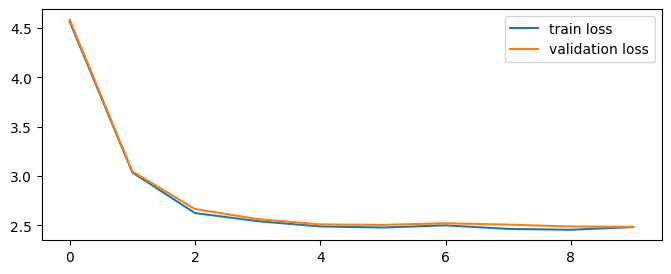

In [25]:
fig, ax_l = plt.subplots(1, 1, figsize=(8,3))
ax_l.plot(np.array(loss_history["train"]).flatten(), label = 'train loss')
ax_l.plot(np.array(loss_history["val"]).flatten(), label = 'validation loss')
ax_l.legend()

### Averaging past context by multiplication on triangle matrix

In [26]:
x = torch.randn(batch_size, block_size, vocab_size)
x.shape

torch.Size([32, 8, 65])

### straightforward implementation

In [27]:
def straightforward_averaging():
    xbow = torch.zeros((batch_size, block_size, vocab_size))
    for b in range(batch_size):
        for t in range(block_size):
            xprev = x[b,:t+1]
            xbow[b,t] = torch.mean(xprev, 0)
    return xbow

xbow = straightforward_averaging()

In [28]:
%timeit straightforward_averaging()

3.93 ms ± 38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Optimized implementation by matmul

In [29]:
def matmull_averaging():
    wei = torch.tril(torch.ones((block_size, block_size)))
    wei = wei / wei.sum(1, keepdim=True)
    return wei @ x

xbow2 = matmull_averaging()

In [30]:
%timeit matmull_averaging()

121 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
torch.allclose(xbow, xbow2)

False

In [32]:
idx = torch.isclose(xbow, xbow2) == False
xbow[idx], xbow2[idx]

(tensor([ 2.1373e-03,  3.1831e-04,  2.7281e-04, -1.3027e-03,  1.4255e-03,
          5.5671e-05, -3.3516e-03, -1.4733e-03, -1.5935e-03, -1.5371e-03,
         -8.3896e-04, -2.6058e-04]),
 tensor([ 2.1374e-03,  3.1829e-04,  2.7283e-04, -1.3027e-03,  1.4255e-03,
          5.5689e-05, -3.3516e-03, -1.4733e-03, -1.5934e-03, -1.5371e-03,
         -8.3894e-04, -2.6059e-04]))

### Implementation with Softmax

In [33]:
def softmax_averaging():
    tril = torch.tril(torch.ones((block_size, block_size)))
    wei = torch \
        .zeros((block_size, block_size)) \
        .masked_fill(tril == 0, float("-inf"))
    wei = F.softmax(wei, dim=1)
    return wei @ x
xbow3 = softmax_averaging()

In [34]:
%timeit softmax_averaging()

139 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [35]:
torch.allclose(xbow,xbow3)

False

In [36]:
idx = torch.isclose(xbow, xbow3) == False
xbow[idx], xbow3[idx]

(tensor([ 2.1373e-03,  3.1831e-04,  2.7281e-04, -1.3027e-03,  1.4255e-03,
          5.5671e-05, -3.3516e-03, -1.4733e-03, -1.5935e-03, -1.5371e-03,
         -8.3896e-04, -2.6058e-04]),
 tensor([ 2.1374e-03,  3.1829e-04,  2.7283e-04, -1.3027e-03,  1.4255e-03,
          5.5689e-05, -3.3516e-03, -1.4733e-03, -1.5934e-03, -1.5371e-03,
         -8.3894e-04, -2.6059e-04]))

### Bigram language model with Linear layer

In [37]:
class BigramLanguageModel2(BigramLanguageModel):
    def __init__(self, vocab_size, embedding_dims):
        super().__init__(vocab_size, embedding_dims)
        self.lm_head = nn.Linear(embedding_dims, vocab_size)

    def forward(self, idx):
        token_embeddings = super().forward(idx)
        return self.lm_head(token_embeddings)


embedding_dims = 32
model2 = BigramLanguageModel2(vocab_size, embedding_dims).to(device)
logits = model2(xb)
loss = model2.compute_loss(logits, yb)
print(logits.shape)
print(loss)

torch.Size([4, 8, 65])
tensor(4.2152, device='cuda:0', grad_fn=<NllLossBackward0>)


In [38]:
print(model2.generate_string(initial_context, max_new_tokens=100))


3LDblw!AOItGelLbRJZwRZiSgOxzwz Lh$aGxQZwwX$eUCzjIISG:;t;gvXjRxb yBO&hH!-FFj&tmNTWBlK!mAoH!gATMm
ol;r


In [39]:
optimizer = torch.optim.AdamW(model2.parameters(), lr=1e-2)
loss_history = train(
    model = model2,
    iterations = 2000,
    batch_size = 32,
    optimizer = optimizer,
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10),
    loss_estimator = LossEstimator(eval_step=200)
)

step 0 losses: train 4.3989, val 4.3989, 
step 200 losses: train 2.5556, val 2.5556, 
step 400 losses: train 2.4846, val 2.4846, 
step 600 losses: train 2.4989, val 2.4989, 
step 800 losses: train 2.4787, val 2.4787, 
step 1000 losses: train 2.4891, val 2.4891, 
step 1200 losses: train 2.4993, val 2.4993, 
step 1400 losses: train 2.5051, val 2.5051, 
step 1600 losses: train 2.4904, val 2.4904, 
step 1800 losses: train 2.5234, val 2.5234, 


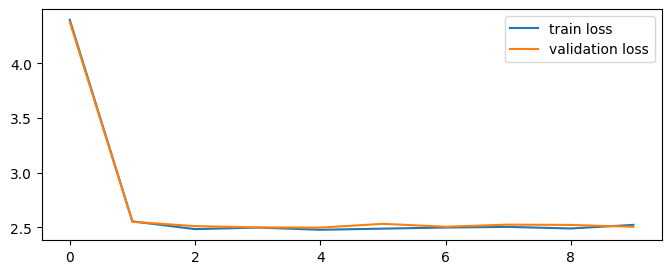

In [40]:
fig, ax_l = plt.subplots(1, 1, figsize=(8,3))
ax_l.plot(np.array(loss_history["train"]).flatten(), label = 'train loss')
ax_l.plot(np.array(loss_history["val"]).flatten(), label = 'validation loss')
ax_l.legend()

In [41]:
print(model2.generate_string(initial_context, max_new_tokens=500))


ULe t jura d f t wothrmu th?

Shaimarmas, h n t il c; d juslotor Whthanlll my ay meras be:
HEAy o n, nbust RIUCE:


Anveabae; IOn hequ the an nu tonm THEEO:
e y, d.
Glige, iss y eyot,
BURO:
BRKENERYe
The s; s omengre;
HARINGor ars, es s;

ICld t olk ve, scee Clllothenjee ORWheresed we h, st ar
ENCELONS d.
LINus derk he kn wen h ppril
'd! WANELUSThrwshe. ar?
EEThar INISist athe couf mhir, byoass houng, hathese haway,
ANTnd end,
My waflouth s wat than ccr courcilt, omamonge,
Youlateald weat r thea


### Bigram language model with position embeddings

In [42]:
class PositionalBigramLanguageModel(BigramLanguageModel):
    def __init__(self, block_size, vocab_size, embedding_dims):
        super().__init__(vocab_size, embedding_dims)
        self.block_size = block_size
        self.position_embedding_table = nn.Embedding(block_size, embedding_dims)
        self.lm_head = nn.Linear(embedding_dims, vocab_size)

    def forward(self, idx):
        N, T = idx.shape
        token_embeddings = super().forward(idx)
        position_embedds = self.position_embedding_table(torch.arange(T, device=device))
        mixed_embedds = token_embeddings + position_embedds
        return self.lm_head(mixed_embedds)

    def generate(self, initial_context, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(initial_context[:, -self.block_size:])
            last_time_step_logits = logits[:,-1,:]
            probs = F.softmax(last_time_step_logits, dim=1)
            context_next = torch.multinomial(probs, num_samples=1)
            initial_context = torch.cat((initial_context, context_next), dim=1)
        return initial_context


positionalModel = PositionalBigramLanguageModel(block_size, vocab_size, embedding_dims).to(device)
logits = positionalModel.forward(xb)
loss = positionalModel.compute_loss(logits, yb)
print(loss.item())
print(positionalModel.generate_string(initial_context, max_new_tokens=100))

4.426414966583252

&j.Ef&ioHDBg'PCWz!rzwbu-NrB&?$'liYyGv'lwWl&g  zqS'$fjZNX-ViDmzwq$BawZ;$Fk:Pq-B!'QnJuBNzoPHy!pmMzw,!R


In [43]:
optimizer = optim.AdamW(positionalModel.parameters(), lr=1e-2, weight_decay=1e-5)
loss_history = train(
    model = positionalModel,
    iterations = 2000,
    batch_size = 32,
    optimizer = optimizer,
    lr_scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3),
    loss_estimator = LossEstimator(eval_step=200)
)

step 0 losses: train 4.3941, val 4.3941, 
step 200 losses: train 2.6001, val 2.6001, 
step 400 losses: train 2.5359, val 2.5359, 
step 600 losses: train 2.5008, val 2.5008, 
step 800 losses: train 2.5243, val 2.5243, 
step 1000 losses: train 2.4951, val 2.4951, 
step 1200 losses: train 2.5118, val 2.5118, 
step 1400 losses: train 2.4977, val 2.4977, 
step 1600 losses: train 2.5257, val 2.5257, 
step 1800 losses: train 2.5058, val 2.5058, 


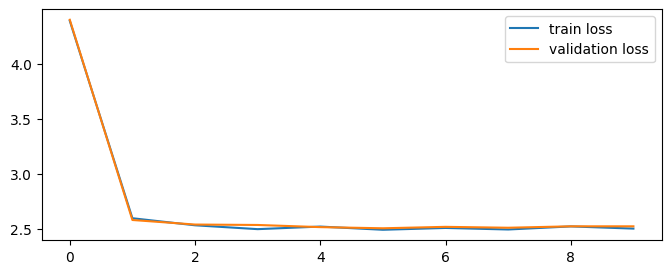

In [44]:
fig, ax_l = plt.subplots(1, 1, figsize=(8,3))
ax_l.plot(np.array(loss_history["train"]).flatten(), label = 'train loss')
ax_l.plot(np.array(loss_history["val"]).flatten(), label = 'validation loss')
ax_l.legend()

In [45]:
print(positionalModel.generate_string(initial_context, max_new_tokens=1000))


NGowavonseat,
JUS: d bu y Gofad
,
JUCUPR pat ingr brifo s men'ed.
Whathee s his ote h henike a 
Mares; e lane.
O trr, his? kele y bet citinorirongh ry, higo m fas; th ade,
AMu t htereerd
BE:
TUR:
NCour isenookie w I't O:
ST:
ILIm prinetowed amand e
Sore ofouse sis is ith y de
TERe hed COfad ym o thando yo ory be mand h lomed h t:
3 ther tl mor, s



PEdshenceadad, hore mma unest s y areaseds!
E:
Cadriey meawhe ainon mapr, u ouril had be.
y, d sloreveke ckst da my s,
DWhy 's o he vous.


ERCE pan.
ot f Larerar, m nof marolllcig ht thir woorowait ty, y:
Jo he wik slld fofud
As mowinequt cemaner myoue.
'lindwo.
YO:
TAst f at st, Clotheighaig trvageghor A.
And! haverdr e
ANI , ch n ale wind RI I htow'd ; w s atorth:
Norire my akr f ce mo m.


errdd, hayessloul fotheremp dth me we weirg onecldil h, ncut;
D:
Whiethier,

IONETHARY arofarkered wncende is, t thid bickit s is,
ALOre buto ghangr watowht won heBRoleg, yerm aikngol ithe.
Thamyishegun inde no

Le: tom bence Whe.
ASouy corimangich E